<a href="https://colab.research.google.com/github/UrbanGISer/UrbanAnalytics/blob/main/CommunityScan/Code/Network_Community_Scanning_for_UA_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Delineating urban agglomeration regions in China by network community scanning: Structures and policy implications
Cities, 2025, **Lingbo Liu, Fahui Wang**, https://doi.org/10.1016/j.cities.2025.105721

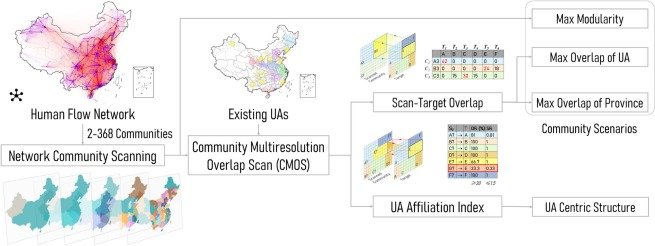

# 01-Read Baidu Mobility Data and Install Dependent Packages
Baidu Qianxi(Mobility Data) 01/01/2023 - 12/31/2023
Shared on [GitHub](https://github.com/UrbanGISer/UrbanAnalytics/tree/main/CommunityScan/Data)

In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('https://github.com/UrbanGISer/UrbanAnalytics/raw/refs/heads/main/CommunityScan/Data/BaiduMobility2023.csv')

In [35]:
df.head()

,Source,Target,Scale
0,110000,120000,535.803290
1,110000,130100,131.871305
2,110000,130200,117.864777
3,110000,130300,123.759656
4,110000,130400,97.377307


In [3]:
!pip install leidenalg igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 53.8 MB/s eta 0:00:00


# 02 - Network Community Scanning

In [4]:
import networkx as nx
import pandas as pd
import numpy as np
import igraph as ig
import leidenalg as la
from joblib import Parallel, delayed, cpu_count
from tqdm import tqdm
import copy

## 02 -1 Exploratory Network Community Scanning

In [15]:
#Compute community partition
def compute_partition(edges, source='Source', target='Target', weight_col='Scale', resolution=1.0):
    G_temp = nx.from_pandas_edgelist(edges, source=source, target=target, edge_attr=True)
    G1_temp = ig.Graph.from_networkx(G_temp)
    weights = np.array(G1_temp.es[weight_col])
    partition = la.find_partition(
        G1_temp,
        la.RBConfigurationVertexPartition,
        weights=weights,
        resolution_parameter=resolution
    )
    modularity = G1_temp.modularity(partition.membership, weights=weights)

    return {
        'resolution': resolution,
        'clusters': len(set(partition.membership)),
        'membership': partition.membership,
        'modularity': modularity
    }

In [25]:
#Compute community partition
def pre_network_community_scanning(input_df, resolution_list, source_col='Source',
                                 target_col='Target', weight_col='Scale', mode='pre', n_jobs=-1):
    edges = input_df[[source_col, target_col, weight_col]]
    unique_nodes = len(set(input_df[source_col]).union(set(input_df[target_col])))

    precomputed_results = Parallel(n_jobs=n_jobs, prefer="threads")(
        delayed(compute_partition)(
            edges,
            source=source_col,
            target=target_col,
            weight_col=weight_col,
            resolution=res
        ) for res in tqdm(resolution_list, desc="Precomputing Partitions")
    )

    summary_df = pd.DataFrame(precomputed_results)
    summary_df['resolution'] = summary_df['resolution'].astype(float)
    if mode =='pre':
      summary_stats = summary_df.dropna().groupby('clusters').apply(
          lambda x: x.loc[x['modularity'].idxmax()]
      ).reset_index(drop=True)

      summary_stats = summary_stats.set_index('clusters').reindex(
          range(2, unique_nodes)
      ).reset_index().fillna(np.nan)
      summary_df=summary_stats
    return summary_df

## 02-2 Binary Search for Network Community Scanning

In [41]:
def binary_search_task(edges, target_clusters_list, summary_stats, n_max=5):
    search_results = []
    missing_clusters = summary_stats.loc[summary_stats['resolution'].isna(), 'clusters'].tolist()
    summary_stats_copy = summary_stats.copy()
    missing_clusters_copy = missing_clusters.copy()

    for target_clusters in target_clusters_list:
        if target_clusters not in missing_clusters_copy:
            print(f"[Binary Search] Target cluster {target_clusters} already computed. Skipping.")
            continue

        lower_res = summary_stats_copy.loc[summary_stats_copy['clusters'] < target_clusters, 'resolution'].dropna()
        upper_res = summary_stats_copy.loc[summary_stats_copy['clusters'] > target_clusters, 'resolution'].dropna()

        if len(lower_res) == 0:
            lower_res = 0.1
        else:
            lower_res = lower_res.max()

        if len(upper_res) == 0:
            upper_res = 1000
        else:
            upper_res = upper_res.min()

        resolution = (lower_res + upper_res) / 2

        iteration, max_iterations = 0, n_max
        while iteration < max_iterations:
            result = compute_partition(
                edges,
                source='Source',
                target='Target',
                weight_col='Scale',
                resolution=resolution
            )

            clusters = result['clusters']
            membership = result['membership']
            modularity = result['modularity']

            search_results.append((clusters,resolution, membership,modularity ))
            print(f"[Binary Search] Target clusters: {target_clusters}, Current resolution: {resolution:.5f}, Found clusters: {clusters}")

            if clusters in missing_clusters_copy:
                summary_stats_copy.loc[summary_stats_copy['clusters'] == clusters, 'resolution'] = result['resolution']
                missing_clusters_copy.remove(clusters)
                break

            if clusters == target_clusters:
                break
            elif clusters < target_clusters:
                lower_res = resolution
            else:
                upper_res = resolution

            if abs(upper_res - lower_res) < 1e-6:
                print(f"[Binary Search] Search converged for target {target_clusters}")
                break

            resolution = (lower_res + upper_res) / 2
            iteration += 1

        if iteration == max_iterations:
            print(f"[Binary Search] Reached maximum iterations for target {target_clusters}")

    return search_results

def ncs_binary(input_df, summary_stats, n_max=5, n_jobs=-1):
    edges = input_df[['Source', 'Target', 'Scale']]
    n_jobs = cpu_count() if n_jobs == -1 else n_jobs
    missing_clusters = summary_stats.loc[summary_stats['resolution'].isna(), 'clusters'].tolist()

    if not missing_clusters:
        print("[Binary Search] No missing clusters to process")
        return []

    cluster_chunks = np.array_split(sorted(missing_clusters), n_jobs)

    for idx, chunk in enumerate(cluster_chunks):
        if len(chunk) > 0:
            print(f"[Binary Search] CPU {idx + 1} handling clusters from {chunk[0]} to {chunk[-1]}")

    results = Parallel(n_jobs=n_jobs, prefer="threads")(
        delayed(binary_search_task)(edges, chunk, summary_stats, n_max)
        for chunk in cluster_chunks if len(chunk) > 0
    )

    return results

In [20]:
def update_stats(summary_stats,all_results):
  # Flattening the nested list of tuples into a single list
  flattened_results = [item for sublist in all_results for item in sublist]
  # Convert the flattened list to a DataFrame
  all_results_df = pd.DataFrame(flattened_results, columns=['clusters', 'resolution', 'membership','modularity'])
  # Concatenate 2 dataframes
  combined_df = pd.concat([all_results_df, summary_stats], ignore_index=True).sort_values('clusters')
  # Fill NaN values in 'modularity' with a suitable value (e.g., -inf) before grouping
  combined_df['modularity'] = combined_df['modularity'].fillna(float('-inf'))
  # Group by 'clusters' and select the row with the maximum 'modularity' within each group
  combined_df = combined_df.loc[combined_df.groupby('clusters')['modularity'].idxmax()]
  # Reset the index
  combined_df = combined_df.reset_index(drop=True)

  na_count = combined_df['resolution'].isna().sum()
  # print(f"The number of NA values in 'resolution' column is: {na_count}")
  return combined_df,na_count

## 02-3 Run Network Community Scanning with Binary Search

### **Step 1 Network Community Scanning**

In [42]:
precomputed_resolutions = list(np.arange(0.1, 1.1, 0.1)) + list(range(1, 101)) + list(range(100, 3000, 100))

In [43]:
summary_stats = pre_network_community_scanning(df,precomputed_resolutions,source_col='Source',
                                 target_col='Target', weight_col='Scale',)

Precomputing Partitions: 100%|██████████| 139/139 [02:02<00:00,  1.14it/s]
<ipython-input-25-9582d6f40117>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_stats = summary_df.dropna().groupby('clusters').apply(


In [73]:
na_count=1
while na_count>0:
  all_results = ncs_binary(df,summary_stats,n_max=5,n_jobs=-1)
  summary_stats,na_count=update_stats(summary_stats,all_results)
  print(f"The number of NA values in 'resolution' column is: {na_count}")

[Binary Search] CPU 1 handling clusters from 4 to 193
[Binary Search] CPU 2 handling clusters from 199 to 358
[Binary Search] Target clusters: 4, Current resolution: 0.22500, Found clusters: 4
[Binary Search] Target clusters: 199, Current resolution: 52.56250, Found clusters: 198
[Binary Search] Target clusters: 14, Current resolution: 1.17500, Found clusters: 14
[Binary Search] Target clusters: 199, Current resolution: 52.84375, Found clusters: 198
[Binary Search] Target clusters: 199, Current resolution: 52.98438, Found clusters: 200
[Binary Search] Target clusters: 18, Current resolution: 1.77500, Found clusters: 19
[Binary Search] Target clusters: 199, Current resolution: 52.91406, Found clusters: 200
[Binary Search] Target clusters: 18, Current resolution: 1.73750, Found clusters: 19
[Binary Search] Target clusters: 199, Current resolution: 52.87891, Found clusters: 198
[Binary Search] Reached maximum iterations for target 199
[Binary Search] Target clusters: 18, Current resolutio

In [74]:
summary_stats

,clusters,resolution,membership,modularity
0,2,0.100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.033024
1,3,0.200,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.454997
2,4,0.225,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.569846
3,5,0.250,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.575840
4,6,0.300,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.647493
...,...,...,...,...
362,364,900.000,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...",-0.005925
363,365,1000.000,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",-0.006326
364,366,1500.000,"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...",-0.006625
365,367,1800.000,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",-0.006975


### **Step 2 Plot Resolution VS Modularity and Cluster**

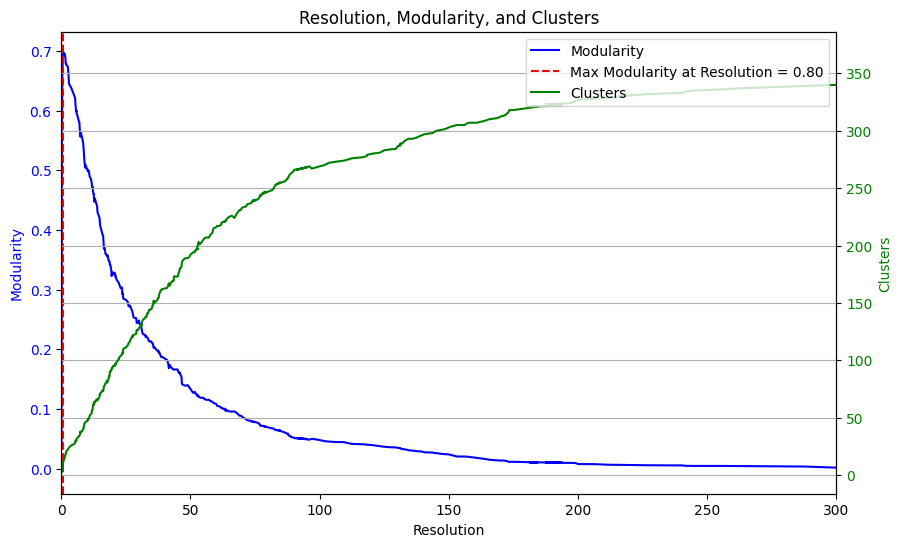

In [28]:
import matplotlib.pyplot as plt
final_df=summary_stats
# Find the resolution value where modularity is maximum
max_modularity_resolution = final_df.loc[final_df['modularity'].idxmax(), 'resolution']

# Create the line plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot resolution and modularity on the primary y-axis
ax1.plot(final_df['resolution'], final_df['modularity'], color='blue', label='Modularity')
ax1.set_xlabel('Resolution')
ax1.set_ylabel('Modularity', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add a vertical line at the maximum modularity
ax1.axvline(x=max_modularity_resolution, color='red', linestyle='--', label=f'Max Modularity at Resolution = {max_modularity_resolution:.2f}')


# Create a secondary y-axis for clusters
ax2 = ax1.twinx()
ax2.plot(final_df['resolution'], final_df['clusters'], color='green', label='Clusters')
ax2.set_ylabel('Clusters', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Set title and display the plot
plt.title('Resolution, Modularity, and Clusters')
plt.xlim(0, 300)

plt.grid(True)
plt.show()

### **Step 3 Extract Partition Result Table**

In [85]:
import pandas as pd

def transform_membership_with_nodes(final_df, input_df, source_col, target_col):
    G_temp = nx.from_pandas_edgelist(input_df, source=source_col, target=target_col)
    G1_temp = ig.Graph.from_networkx(G_temp)
    nx_nodes = list(G_temp.nodes)

    cluster_columns = {'node': nx_nodes}

    for _, row in final_df.iterrows():
        cluster_id = int(row['clusters'])
        membership_list = row['membership']

        if len(membership_list) == len(nx_nodes):
            cluster_columns[cluster_id] = membership_list
        else:
            print(f"Warning: Membership list length does not match nx_nodes for cluster {cluster_id}")

    result_df = pd.DataFrame(cluster_columns)
    result_df = result_df.reset_index(drop=True).rename(columns={'node': 'code'})

    return result_df

In [107]:
result_df=transform_membership_with_nodes(summary_stats, df, source_col='Source', target_col='Target')

In [108]:
result_df

,code,2,3,4,5,6,7,8,9,10,...,359,360,361,362,363,364,365,366,367,368
0,110000,0,0,0,0,0,1,2,0,6,...,9,9,8,7,6,5,4,3,2,1
1,120000,0,0,0,0,0,1,2,0,6,...,10,10,9,8,7,6,5,4,3,2
2,130100,0,0,0,0,0,1,2,0,6,...,11,11,10,9,8,7,6,5,4,3
3,130200,0,0,0,0,0,1,2,0,6,...,12,12,11,10,9,8,7,6,5,4
4,130300,0,0,0,0,0,1,2,0,6,...,13,13,12,11,10,9,8,7,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,659008,1,2,2,2,2,5,1,6,7,...,355,356,357,358,359,360,361,362,363,364
365,659009,1,2,2,2,2,5,1,6,7,...,6,6,4,4,4,2,1,2,1,0
366,710000,0,1,1,1,1,0,0,8,9,...,356,357,358,359,360,361,362,363,364,365
367,810000,0,1,1,1,1,0,0,1,0,...,357,358,359,360,361,362,363,364,365,366


# 03- Community Multiresolution Overlap Scan

## 03-1 Read UA Table

In [29]:
dfua=pd.read_csv('https://github.com/UrbanGISer/UrbanAnalytics/raw/refs/heads/main/CommunityScan/Data/ChinaBaiduCity369.csv')

In [30]:
dfua.head()

,GbCode,CityName,lat,lon,GbProv,UA_Full,UA
0,110000,Beijing,39.910925,116.413384,11,Beijing-Tianjin-Hebei,BTH
1,120000,Tianjin,39.091103,117.208093,12,Beijing-Tianjin-Hebei,BTH
2,130100,Shijiazhuang,38.048312,114.521532,13,Beijing-Tianjin-Hebei,BTH
3,130200,Tangshan,39.636584,118.186459,13,Beijing-Tianjin-Hebei,BTH
4,130300,Qinhuangdao,39.894727,119.525967,13,Beijing-Tianjin-Hebei,BTH


In [110]:
result_df.rename(columns={'code': 'GbCode'}, inplace=True)

In [111]:
result_df.head()

,GbCode,2,3,4,5,6,7,8,9,10,...,359,360,361,362,363,364,365,366,367,368
0,110000,0,0,0,0,0,1,2,0,6,...,9,9,8,7,6,5,4,3,2,1
1,120000,0,0,0,0,0,1,2,0,6,...,10,10,9,8,7,6,5,4,3,2
2,130100,0,0,0,0,0,1,2,0,6,...,11,11,10,9,8,7,6,5,4,3
3,130200,0,0,0,0,0,1,2,0,6,...,12,12,11,10,9,8,7,6,5,4
4,130300,0,0,0,0,0,1,2,0,6,...,13,13,12,11,10,9,8,7,6,5


In [136]:
# Drop rows where 'UA' is 'NA'
dfua_na = dfua[dfua['UA'].notna() & (dfua['UA'] != 'NA')]

In [137]:
dfua_na

,GbCode,CityName,lat,lon,GbProv,UA_Full,UA
0,110000,Beijing,39.910925,116.413384,11,Beijing-Tianjin-Hebei,BTH
1,120000,Tianjin,39.091103,117.208093,12,Beijing-Tianjin-Hebei,BTH
2,130100,Shijiazhuang,38.048312,114.521532,13,Beijing-Tianjin-Hebei,BTH
3,130200,Tangshan,39.636584,118.186459,13,Beijing-Tianjin-Hebei,BTH
4,130300,Qinhuangdao,39.894727,119.525967,13,Beijing-Tianjin-Hebei,BTH
...,...,...,...,...,...,...,...
355,654200,Tacheng,46.750948,82.987236,65,North Tianshan Slope,NTS
357,659001,Shihezi,44.311976,86.086886,65,North Tianshan Slope,NTS
360,659004,Wujiaqu,44.172445,87.549937,65,North Tianshan Slope,NTS
367,810000,HongKong,22.246500,114.209600,81,Great Bay of Guangdong-Macau-Hongkong,GB


## 03-2 Run CMOS- STO



In [112]:
def STO(df1, df2, cluster_column, code_column):
    """
    Calculate optimal cluster assignments using the Hungarian algorithm.

    Parameters:
    -----------
    df1 : pandas.DataFrame
        First dataframe containing cluster assignments
    df2 : pandas.DataFrame
        Second dataframe containing scan results
    cluster_column : str
        Name of the cluster column in df1
    code_column : str
        Name of the code column in both dataframes

    Returns:
    --------
    pandas.DataFrame
        Results dataframe with optimal assignments
    """
    import pandas as pd
    import numpy as np
    from scipy.optimize import linear_sum_assignment

    # Get columns to compare (all columns in df2 except code_column)
    scan_result_columns = df2.columns[1:]

    # Get unique clusters
    clusters = df1[cluster_column].unique()

    # Initialize results dataframe
    results_df = pd.DataFrame(0, index=clusters, columns=scan_result_columns)

    # Create dictionary of cluster groups
    cluster_groups = df1.groupby(cluster_column)[code_column].apply(set).to_dict()

    # Process each column
    for col in scan_result_columns:
        # Create dictionary of column groups
        column_groups = df2.groupby(col)[code_column].apply(set).to_dict()

        # Create cost matrix for linear assignment
        cost_matrix = pd.DataFrame(-np.inf,
                                 index=column_groups.keys(),
                                 columns=clusters)

        # Calculate overlap between each cluster and column group
        for column_key, column_group in column_groups.items():
            for cluster_value, cluster_group in cluster_groups.items():
                overlap = len(cluster_group & column_group)
                cost_matrix.loc[column_key, cluster_value] = -overlap

        # Ensure cost matrix contains only numeric values
        cost_matrix = cost_matrix.fillna(0).astype(float)

        # Find optimal assignment using Hungarian algorithm
        row_ind, col_ind = linear_sum_assignment(cost_matrix.to_numpy())

        # Save results
        for row1, col1 in zip(row_ind, col_ind):
            column_key = cost_matrix.index[row1]
            cluster_value = clusters[col1]
            results_df.loc[cluster_value, col] = -cost_matrix.loc[column_key, cluster_value]

    return results_df

In [138]:
# Get Scan to Target Ovarlap
result_STO = STO(
    df1=dfua_na,
    df2=result_df,
    cluster_column='UA',
    code_column='GbCode',
)

In [139]:
result_STO

,2,3,4,5,6,7,8,9,10,11,...,359,360,361,362,363,364,365,366,367,368
BTH,0,0,0,0,0,0,0,0,10,10,...,1,1,1,1,1,1,1,1,1,1
CP,0,0,0,0,25,0,25,18,18,18,...,1,1,1,1,1,1,1,1,1,1
CS,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GP,0,0,9,9,9,10,9,10,10,10,...,1,1,1,1,1,1,1,1,1,1
HBOY,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
SCL,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
HC,0,0,0,0,0,11,11,11,11,11,...,1,1,1,1,1,1,1,1,1,1
YRD,33,33,33,33,33,33,33,33,33,33,...,1,1,1,1,1,1,1,1,1,1
WCOTS,0,0,0,0,0,0,13,9,9,9,...,1,1,1,1,1,1,1,1,1,1
MRYR,0,30,30,30,30,30,13,17,17,13,...,1,1,1,1,1,1,1,1,1,1


In [140]:
def calculate_GB_metrics(result_STO, dfua_na, cluster_column='UA', code_column='GbCode'):

    import pandas as pd

    # Group by province and count codes
    code_counts = dfua.groupby(cluster_column)[code_column].count()

    # Merge counts with STO results
    result = result_STO.merge(code_counts,
                            left_index=True,
                            right_index=True,
                            how='left')

    # Calculate proportions for each column
    for col in result.columns[:-1]:  # Exclude the code count column
        result[col] = result[col] / result[code_column]

    # Calculate mean proportions and create final DataFrame
    final_result = pd.DataFrame(
        result.drop(columns=[code_column]).mean(),
        columns=[cluster_column]
    )

    return final_result

In [141]:
result_ST_Gb=calculate_GB_metrics(result_STO, dfua_na, cluster_column='UA', code_column='GbCode')

In [142]:
result_ST_Gb

,UA
2,0.105263
3,0.157895
4,0.205263
5,0.226316
6,0.270175
...,...
364,0.118474
365,0.118474
366,0.118474
367,0.118474


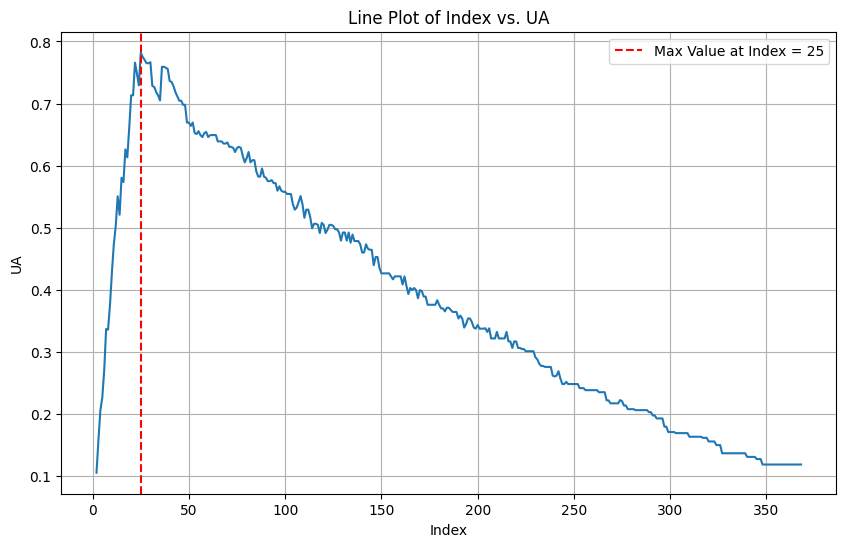

In [144]:
cluster_column='UA'

import matplotlib.pyplot as plt

# Assuming result_ST_Gb is a pandas DataFrame with an index and a 'GB' column
# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(result_ST_Gb.index, result_ST_Gb[cluster_column])
plt.xlabel('Index')
plt.ylabel(cluster_column)
plt.title(f'Line Plot of Index vs. {cluster_column}')

# Find the index of the maximum value in the 'GB' column
max_index = result_ST_Gb[cluster_column].idxmax()

# Add a vertical line at the maximum value
plt.axvline(x=max_index, color='red', linestyle='--', label=f'Max Value at Index = {max_index}')

# Add legend and display the plot
plt.legend()
plt.grid(True)
plt.show()

## 03-3 Run CMOS- CAI

In [151]:
def community_affiliation_index(df1, df2, cluster_name ='UA',codename='GbCode',overlap_threshold=30, size_multiplier=1.5):

    import pandas as pd

    # Get unique UA values from df1
    unique_ua_values = df1[cluster_name].unique()

    # Initialize results DataFrame
    all_results = pd.DataFrame(columns=['UA', 'Column', 'Overlap Percentage', 'Codes'])

    # For each unique UA value in df1
    for ua_value in unique_ua_values:
        # Filter df1 to get only rows for current UA value
        df1_filtered = df1[df1[cluster_name] == ua_value]

        # Get reference codes for current UA
        gbcode = set(df1_filtered[codename].tolist())

        # Create df3 without Code column
        df3 = df2.drop(columns=[codename])

        # Process columns in reverse order
        for col in reversed(df3.columns):
            # Get community codes for current column
            community_codes_list = df2.groupby(col)[codename].apply(set).tolist()

            # Flag to control column processing
            should_continue = True

            # Process each community's codes
            for codes in community_codes_list:
                # Calculate overlap
                overlap = len(codes & gbcode)
                overlap_percentage = overlap / len(gbcode) * 100

                # Check overlap conditions
                if overlap_percentage >= overlap_threshold:
                    if len(codes) <= (len(gbcode) * size_multiplier):
                        # Add results to DataFrame
                        new_row = pd.DataFrame({
                            'UA': [ua_value],
                            'Column': [col],
                            'Overlap Percentage': [overlap_percentage],
                            'Codes': [list(codes)]
                        })
                        all_results = pd.concat([all_results, new_row], ignore_index=True)
                    else:
                        should_continue = False
                        break

            # Break column loop if needed
            if not should_continue:
                break



    return all_results

In [152]:
cai_results=community_affiliation_index(dfua_na, result_df, cluster_name ='UA',codename='GbCode',overlap_threshold=30, size_multiplier=1.5)

<ipython-input-151-c6ecee42ac88>:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_results = pd.concat([all_results, new_row], ignore_index=True)


In [154]:
# Explode the Codes column to create separate rows for each code
expanded_results = (cai_results.explode('Codes')
                    .reset_index(drop=True))

In [172]:

# Extract the unique UA values from the expanded_results DataFrame
ua_values = expanded_results['UA'].unique()

# Initialize an empty list to store the results for each UA value
all_ua_results = []

# Loop through each unique UA value
for ua in ua_values:
    # Filter the expanded_results DataFrame for the current UA value
    ua_data = expanded_results[expanded_results['UA'] == ua]

    # Group by 'UA' and 'Codes' and count the occurrences of each code
    code_counts = ua_data.groupby(['UA', 'Codes'])['Codes'].count().reset_index(name='count')

    # Calculate the relative maximum value of 'count' for each UA value
    max_count = code_counts['count'].max()
    code_counts['CAI'] = code_counts['count'] / max_count

    # Append the results for the current UA value to the list
    all_ua_results.append(code_counts)

# Concatenate the results for all UA values into a single DataFrame
final_results1 = pd.concat(all_ua_results)
final_results1

,UA,Codes,count,CAI
0,BTH,110000,50,0.625000
1,BTH,120000,80,1.000000
2,BTH,130100,17,0.212500
3,BTH,130200,80,1.000000
4,BTH,130300,80,1.000000
...,...,...,...,...
8,NTS,659001,199,1.000000
9,NTS,659004,150,0.753769
10,NTS,659005,44,0.221106
11,NTS,659007,83,0.417085


In [173]:

final_results11 = final_results1.sort_values('CAI', ascending=False).drop_duplicates('Codes', keep='first')

final_results11 = final_results11.reset_index(drop=True)
final_results11 = final_results11.sort_values(['Codes','UA' ], ascending=True)


final_results11 = final_results11.reset_index(drop=True)
final_results11

,UA,Codes,count,CAI
0,BTH,110000,50,0.625000
1,BTH,120000,80,1.000000
2,BTH,130100,17,0.212500
3,BTH,130200,80,1.000000
4,BTH,130300,80,1.000000
...,...,...,...,...
328,NTS,659007,83,0.417085
329,NTS,659008,89,0.447236
330,WCOTS,710000,41,0.261146
331,GB,810000,34,0.557377
